In this project we will be predicting the stock price of a company, based on past stock information. We have implemented 2 different LSTM based models to do this. The stock we have chosen to predict the price of is Netflix. By looking at the past 50 days worth of information available on the stock (opening price, closing price, high, low, volume traded), we will predict the next day opening price of the stock.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install alpha_vantage

     |████████████████████████████████| 1.3MB 8.9MB/s 
     |████████████████████████████████| 296kB 27.7MB/s 
     |████████████████████████████████| 143kB 23.0MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163 sha256=95aa97696dfc0f550281202c73036c1c77910f9229e29b4b3a402aa101991edb
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl


In [ ]:
from alpha_vantage.timeseries import TimeSeries

#Download and save daily Netflix stock price from AlphaVantage

def save_dataset(symbol):
    api_key = "S7BZIZFL5XDAWB7Z"    #free API key from AlphaVantage website
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol, outputsize='full')
    data.to_csv('/content/drive/MyDrive/SML_Stocks/NFLX_daily.csv')


save_dataset("NFLX")

**Basic Model**

In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

#number of previous days that will be used to predict a stock price
previous_days = 50

def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    print(data)

    #remove 'date' column- not needed
    data = data.drop(data.columns[0], axis=1)
    print(data)

    #must reorder and reindex data so the oldest stock value comes first and is at index 0
    def reset_my_index(df):
      res = df[::-1].reset_index(drop=True)
      return(res)

    data = reset_my_index(data) 
    print(data)

    #remove first row- firt day of trading. It has an inflated trading volume which would affect normalisation  
    data = data.drop(0, axis=0)  #drop first row
    print(data)

    #normalising data
    normaliser = preprocessing.MinMaxScaler()  #scales data between 0 and 1
    scaled_data = normaliser.fit_transform(data)
    print(scaled_data)

    #get all stock information for the last specified number of days
    previous_stock_info = np.array([scaled_data[i : i + previous_days].copy() for i in range(len(scaled_data) - previous_days)])

    #we will be predicting the stock's next day opening price 
    #get the scaled values for this
    scaled_nextday_price = np.array([scaled_data[:,0][i + previous_days].copy() for i in range(len(scaled_data) - previous_days)])
    scaled_nextday_price = np.expand_dims(scaled_nextday_price, -1)

    #get the non-scaled values for this
    nextday_price = np.array([data.iloc[:,0][i + previous_days].copy() for i in range(len(data) - previous_days)])
    nextday_price = np.expand_dims(nextday_price, -1) 

    #used later to unscale the data
    price_normaliser = preprocessing.MinMaxScaler()
    price_normaliser.fit(nextday_price)   

    return previous_stock_info, scaled_nextday_price, nextday_price, price_normaliser 

previous_stock_info, scaled_nextday_price, nextday_price, price_normaliser = csv_to_dataset('/content/drive/MyDrive/SML_Stocks/NFLX_daily.csv')

            date  1. open   2. high  3. low  4. close  5. volume
0     2020-12-18   533.20  536.3700  526.02    534.45  4502692.0
1     2020-12-17   529.00  535.4900  526.44    532.90  3193377.0
2     2020-12-16   520.11  527.3800  517.69    524.83  3682392.0
3     2020-12-15   518.50  524.7000  513.56    519.78  3398209.0
4     2020-12-14   505.44  524.1603  501.18    522.42  5770424.0
...          ...      ...       ...     ...       ...        ...
4673  2002-05-30    15.51   15.5100   15.00     15.00   725300.0
4674  2002-05-29    16.30   16.3000   15.20     15.45   482700.0
4675  2002-05-28    16.99   17.2500   16.20     16.20   472100.0
4676  2002-05-24    17.00   17.1500   16.76     16.94   793200.0
4677  2002-05-23    16.19   17.4000   16.04     16.75  7485000.0

[4678 rows x 6 columns]
      1. open   2. high  3. low  4. close  5. volume
0      533.20  536.3700  526.02    534.45  4502692.0
1      529.00  535.4900  526.44    532.90  3193377.0
2      520.11  527.3800  517.69    5

In [ ]:
#Creating training and testing sets
n = int(previous_stock_info.shape[0] * 0.9)

stock_info_train = previous_stock_info[:n]
price_train = scaled_nextday_price[:n]

stock_info_test = previous_stock_info[n:]
price_test = scaled_nextday_price[n:]

nextday_price_test = nextday_price[n:]

print('This is n :', n)
print('This is stock info train :', stock_info_train.shape)
print('This is price train :', price_train.shape)
print('This is stock info test:', stock_info_test.shape)
print('This is price test :', price_test.shape)
print('This is next day price test :', nextday_price_test.shape)

This is n : 4164
This is stock info train : (4164, 50, 5)
This is price train : (4164, 1)
This is stock info test: (463, 50, 5)
This is price test : (463, 1)
This is next day price test : (463, 1)


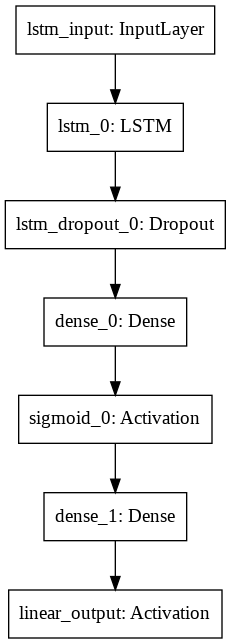

In [ ]:
#Creating the Model

import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)


lstm_input = Input(shape=(previous_days, 5), name='lstm_input')   #dataset has dimension 5
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')

from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
#Training the Model
model.fit(x=stock_info_train, y=price_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate(stock_info_test, price_test)
print(evaluation)

model.save('/content/drive/MyDrive/SML_Stocks/basic_model.h5')

Epoch 1/50
118/118 [==============================] - 5s 27ms/step - loss: 0.0374 - val_loss: 6.1388e-04
Epoch 2/50
118/118 [==============================] - 3s 24ms/step - loss: 0.0017 - val_loss: 4.7792e-04
Epoch 3/50
118/118 [==============================] - 3s 27ms/step - loss: 0.0017 - val_loss: 6.6707e-04
Epoch 4/50
118/118 [==============================] - 3s 26ms/step - loss: 0.0011 - val_loss: 4.9523e-04
Epoch 5/50
118/118 [==============================] - 3s 26ms/step - loss: 7.9406e-04 - val_loss: 4.0637e-04
Epoch 6/50
118/118 [==============================] - 3s 26ms/step - loss: 6.7700e-04 - val_loss: 5.3113e-04
Epoch 7/50
118/118 [==============================] - 3s 26ms/step - loss: 6.1529e-04 - val_loss: 4.3040e-04
Epoch 8/50
118/118 [==============================] - 3s 26ms/step - loss: 8.8690e-04 - val_loss: 3.3641e-04
Epoch 9/50
118/118 [==============================] - 3s 25ms/step - loss: 0.0012 - val_loss: 3.8673e-04
Epoch 10/50
118/118 [==================

In [ ]:
#Evaluating the model

#Unscale the predicted prices
price_test_predicted = model.predict(stock_info_test)
print(price_test_predicted)
price_test_predicted = price_normaliser.inverse_transform(price_test_predicted)
print(price_test_predicted)

mse = np.mean(np.square(nextday_price_test - price_test_predicted))
scaled_mse = mse / (np.max(nextday_price_test) - np.min(nextday_price_test)) * 100   #scale the mse
print(scaled_mse)

[[0.50550926]
 [0.5046536 ]
 [0.5065365 ]
 [0.51045614]
 [0.5113479 ]
 [0.5105798 ]
 [0.50743306]
 [0.50496244]
 [0.49861252]
 [0.49544233]
 [0.49706805]
 [0.49805236]
 [0.48991314]
 [0.49475276]
 [0.49891794]
 [0.5004923 ]
 [0.5040923 ]
 [0.503983  ]
 [0.5083347 ]
 [0.50749606]
 [0.50890577]
 [0.51960045]
 [0.51702464]
 [0.51096064]
 [0.5093509 ]
 [0.50229096]
 [0.49923325]
 [0.49944246]
 [0.5039386 ]
 [0.5105063 ]
 [0.51600367]
 [0.5173427 ]
 [0.5172323 ]
 [0.51240575]
 [0.50944746]
 [0.51112306]
 [0.5110433 ]
 [0.4951949 ]
 [0.48996222]
 [0.48811206]
 [0.4919722 ]
 [0.49965084]
 [0.5086421 ]
 [0.52355397]
 [0.530277  ]
 [0.52563834]
 [0.5235136 ]
 [0.5241047 ]
 [0.52218306]
 [0.5234043 ]
 [0.52895707]
 [0.5344548 ]
 [0.53225744]
 [0.5253868 ]
 [0.5162819 ]
 [0.50815964]
 [0.5049583 ]
 [0.49176854]
 [0.48734146]
 [0.48699468]
 [0.49550676]
 [0.49885333]
 [0.4940772 ]
 [0.4954095 ]
 [0.5015148 ]
 [0.49791265]
 [0.49981272]
 [0.49971485]
 [0.49420804]
 [0.49380702]
 [0.48763174]
 [0.47

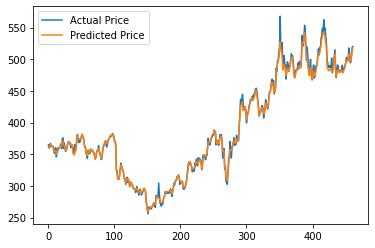

In [ ]:
#Plotting performance

import matplotlib.pyplot as plt

actual_price = plt.plot(nextday_price_test[0:-1], label='Actual Price')
predicted_price = plt.plot(price_test_predicted[0:-1], label='Predicted Price')
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()

As you can see from the graph, the model is able to quite accurately predict the next day opening price of the stock. The model was run 10 times and an average scaled mean square error of 19.41 was achieved. This can be improved by incorporating more information into the model. Financial analysts use functions called "technical indicators" to more accuratley predict the price of stocks. One such technical indicator is called the Simple Moving Average (SMA), which is calculated by taking the average of the last few closing prices of a stock. We will now include the SMA into the model, to see if it increases the accuracy of the prediction.

**Including Technical Indicators**

In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

#number of previous days that will be used to predict a stock price
previous_days = 50

def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    print(data)

    #remove 'date' column- not needed
    data = data.drop(data.columns[0], axis=1)
    print(data)

    #must reorder and reindex data so the oldest stock value comes first and is at index 0
    def reset_my_index(df):
      res = df[::-1].reset_index(drop=True)
      return(res)

    data = reset_my_index(data) 
    print(data)

    #remove first row- firt day of trading. It has an inflated trading volume which would affect normalisation  
    data = data.drop(0, axis=0)  #drop first row
    print(data)

    #normalising data
    normaliser = preprocessing.MinMaxScaler()  #scales data between 0 and 1
    scaled_data = normaliser.fit_transform(data)

    #get all stock information for the last specified number of days
    previous_stock_info = np.array([scaled_data[i : i + previous_days].copy() for i in range(len(scaled_data) - previous_days)])
    
    #we will be predicting the stock's next day opening price 
    #get the scaled values for this
    scaled_nextday_price = np.array([scaled_data[:,0][i + previous_days].copy() for i in range(len(scaled_data) - previous_days)])
    scaled_nextday_price = np.expand_dims(scaled_nextday_price, -1)

    #get the non-scaled values for this
    nextday_price = np.array([data.iloc[:,0][i + previous_days].copy() for i in range(len(data) - previous_days)])
    nextday_price = np.expand_dims(nextday_price, -1) 

    #used later to unscale the data
    price_normaliser = preprocessing.MinMaxScaler()
    price_normaliser.fit(nextday_price)

    sma_list = []
    for his in previous_stock_info:
        # since we are using his[3] we are taking the SMA of the closing price
        sma = np.mean(his[:,3])
        sma_list.append(np.array([sma]))

    sma_list = np.array(sma_list)
		
    sma_normaliser = preprocessing.MinMaxScaler()
    scaled_sma = sma_normaliser.fit_transform(sma_list)

    return previous_stock_info, scaled_nextday_price, nextday_price, price_normaliser, scaled_sma 

previous_stock_info, scaled_nextday_price, nextday_price, price_normaliser, scaled_sma = csv_to_dataset('/content/drive/MyDrive/SML_Stocks/NFLX_daily.csv')

            date  1. open   2. high  3. low  4. close  5. volume
0     2020-12-18   533.20  536.3700  526.02    534.45  4502692.0
1     2020-12-17   529.00  535.4900  526.44    532.90  3193377.0
2     2020-12-16   520.11  527.3800  517.69    524.83  3682392.0
3     2020-12-15   518.50  524.7000  513.56    519.78  3398209.0
4     2020-12-14   505.44  524.1603  501.18    522.42  5770424.0
...          ...      ...       ...     ...       ...        ...
4673  2002-05-30    15.51   15.5100   15.00     15.00   725300.0
4674  2002-05-29    16.30   16.3000   15.20     15.45   482700.0
4675  2002-05-28    16.99   17.2500   16.20     16.20   472100.0
4676  2002-05-24    17.00   17.1500   16.76     16.94   793200.0
4677  2002-05-23    16.19   17.4000   16.04     16.75  7485000.0

[4678 rows x 6 columns]
      1. open   2. high  3. low  4. close  5. volume
0      533.20  536.3700  526.02    534.45  4502692.0
1      529.00  535.4900  526.44    532.90  3193377.0
2      520.11  527.3800  517.69    5

In [ ]:
#Creating training and testing sets
n = int(previous_stock_info.shape[0] * 0.9)

stock_info_train = previous_stock_info[:n]
sma_train = scaled_sma[:n]
price_train = scaled_nextday_price[:n]

stock_info_test = previous_stock_info[n:]
sma_test = scaled_sma[n:]
price_test = scaled_nextday_price[n:]

nextday_price_test = nextday_price[n:]

print('This is n :', n)
print('This is stock info train :', stock_info_train.shape)
print('This is SMA train :', sma_train.shape)
print('This is price train :', price_train.shape)
print('This is stock info test:', stock_info_test.shape)
print('This is SMA test :', sma_test.shape)
print('This is price test :', price_test.shape)
print('This is next day price test :', nextday_price_test.shape)

This is n : 4164
This is stock info train : (4164, 50, 5)
This is SMA train : (4164, 1)
This is price train : (4164, 1)
This is stock info test: (463, 50, 5)
This is SMA test : (463, 1)
This is price test : (463, 1)
This is next day price test : (463, 1)


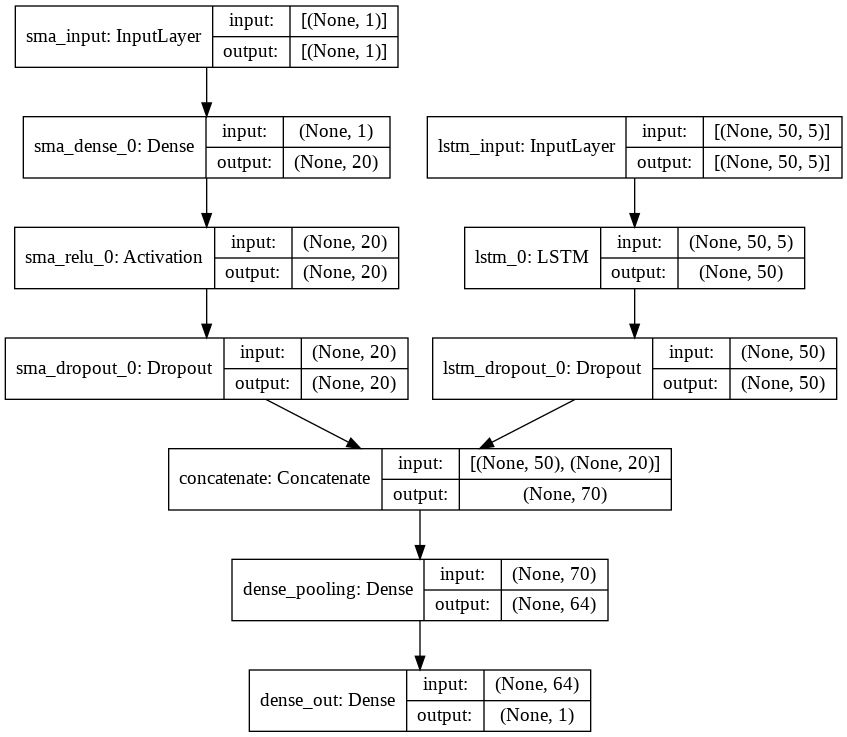

In [ ]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)

#define two sets of inputs
lstm_input = Input(shape=(previous_days, 5), name='lstm_input')
dense_input = Input(shape=(scaled_sma.shape[1],), name='sma_input')
 
#the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)
 
#the second branch operates on the second input
y = Dense(20, name='sma_dense_0')(dense_input)
y = Activation("relu", name='sma_relu_0')(y)
y = Dropout(0.2, name='sma_dropout_0')(y)
sma_branch = Model(inputs=dense_input, outputs=y)
 
#combine the output of the two branches
combined = concatenate([lstm_branch.output, sma_branch.output], name='concatenate')
 
z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)
 
#model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[lstm_branch.input, sma_branch.input], outputs=z)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam,
              loss='mse')

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
#Training the Model
model.fit(x=[stock_info_train, sma_train], y=price_train, batch_size=20, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate([stock_info_test, sma_test], price_test)
print(evaluation)

model.save('/content/drive/MyDrive/SML_Stocks/tecind_model.h5')

Epoch 1/50
188/188 [==============================] - 7s 25ms/step - loss: 0.0147 - val_loss: 0.0015
Epoch 2/50
188/188 [==============================] - 4s 23ms/step - loss: 0.0015 - val_loss: 5.3044e-04
Epoch 3/50
188/188 [==============================] - 4s 23ms/step - loss: 0.0012 - val_loss: 6.3197e-04
Epoch 4/50
188/188 [==============================] - 4s 23ms/step - loss: 8.4082e-04 - val_loss: 5.3683e-04
Epoch 5/50
188/188 [==============================] - 4s 23ms/step - loss: 0.0016 - val_loss: 4.2185e-04
Epoch 6/50
188/188 [==============================] - 4s 23ms/step - loss: 6.7723e-04 - val_loss: 0.0021
Epoch 7/50
188/188 [==============================] - 4s 23ms/step - loss: 9.3427e-04 - val_loss: 3.6310e-04
Epoch 8/50
188/188 [==============================] - 4s 23ms/step - loss: 7.2082e-04 - val_loss: 3.1097e-04
Epoch 9/50
188/188 [==============================] - 4s 23ms/step - loss: 8.6689e-04 - val_loss: 2.7511e-04
Epoch 10/50
188/188 [======================

In [ ]:
#Evaluating the model

#Unscale the predicted prices
price_test_predicted = model.predict([stock_info_test, sma_test])
print(price_test_predicted)
price_test_predicted = price_normaliser.inverse_transform(price_test_predicted)
print(price_test_predicted)

mse = np.mean(np.square(nextday_price_test - price_test_predicted))
scaled_mse = mse / (np.max(nextday_price_test) - np.min(nextday_price_test)) * 100
print(scaled_mse)

[[0.50339144]
 [0.50164974]
 [0.50394404]
 [0.5086538 ]
 [0.50903994]
 [0.5080972 ]
 [0.50475425]
 [0.50275385]
 [0.4964169 ]
 [0.4934302 ]
 [0.49626225]
 [0.49768537]
 [0.4879073 ]
 [0.49477306]
 [0.49947593]
 [0.5007983 ]
 [0.5042821 ]
 [0.50401735]
 [0.50864786]
 [0.5074305 ]
 [0.50954497]
 [0.52156997]
 [0.5169111 ]
 [0.5091444 ]
 [0.5085047 ]
 [0.5010228 ]
 [0.49822435]
 [0.499469  ]
 [0.50542414]
 [0.5124753 ]
 [0.51754063]
 [0.51803076]
 [0.5171425 ]
 [0.51165915]
 [0.50920385]
 [0.51194113]
 [0.5122223 ]
 [0.49493074]
 [0.4899471 ]
 [0.48991448]
 [0.494871  ]
 [0.5008154 ]
 [0.5102168 ]
 [0.5257471 ]
 [0.5305837 ]
 [0.5237705 ]
 [0.52206564]
 [0.5237817 ]
 [0.52192974]
 [0.5247786 ]
 [0.53075445]
 [0.5361464 ]
 [0.53221714]
 [0.5247857 ]
 [0.5150124 ]
 [0.50736475]
 [0.5054239 ]
 [0.49093425]
 [0.48741862]
 [0.48822036]
 [0.49847537]
 [0.5005345 ]
 [0.49404278]
 [0.4960399 ]
 [0.5034478 ]
 [0.49869394]
 [0.500716  ]
 [0.5004575 ]
 [0.4947179 ]
 [0.49487588]
 [0.48807716]
 [0.47

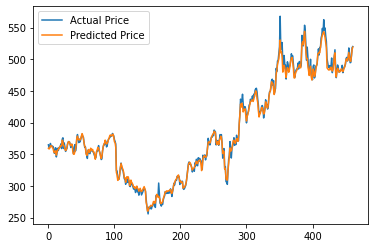

In [ ]:
#Plotting performance
import matplotlib.pyplot as plt

actual_price = plt.plot(nextday_price_test[0:-1], label='Actual Price')
predicted_price = plt.plot(price_test_predicted[0:-1], label='Predicted Price')
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()

By including the SMA information into the model, the performance of it seems to have improved. After running the model 10 times, the average scaled mean square error is 16.91. We will now investigate different values for the hyperparamters of the model to see if we can optimise its performance.

**Hyperparamter Optimisation**

*Number of epochs*-
The number of training epochs was investigated to see how this would affect performance. Epoch values of 10, 30 and 50 were tested. Each one was run 5 times and the average scaled mean squared errors were calculated (results found below). When a particularly large MSE was given, it was removed and the experiment was redone, because this large MSE would skew the average to an unreasonable value.

The average MSE for 10 epochs was 24.28. The average MSE for 30 epochs was 20.72 The average MSE for 50 epochs was 18.41. We can see that the larger the number of epochs, the lower the average MSE, so the better the performance of the model. More than 50 epochs would cause the training time to be too long. We will use 50 epochs for the rest of the tests.         

*Learning Rate*- Next we will investigate the effect of the learning rate on the model performance. Again, when an unusally high MSE is given, the result will be disregarded and repeated. Learning rates of 0.005, 0.0005 and 0.00005 were tested. Each one will be run 5 times and the average MSE will be calculated.

The average MSE for a lr of 0.005 was 30.97. The average MSE for a lr of 0.0005 was 19.65. The average MSE for a lr of 0.00005 was 43.31. Therefore a learning rate of 0.0005 gave the best performance. We will use a learning rate of 0.0005  for the rest of the tests.         

*Batch Size*- Next we will investigate the effect of changing the batch size on the model performance. Again, when an unusally high MSE is given, the result will be disregarded and repeated. Batch sizes of 20, 32 and 44 were tested. Each one will be run 5 times and the average MSE will be calculated.

The average MSE for a batch size of 20 was 16.31. The average MSE for a batch size of 32 was 18.80. The average MSE for a batch size of 44 was 32.95. Therefore a batch size of 20 gave the best performance. 

The best combination of hyperparamters was 50 epochs, learning rate 0.0005, batch size 20, which gave an average scaled mean squared error between 16.31 . We considered using the stock information from multiple different companies to train the model on to help predict a particular company's stock price, however after doing some research we determined that this was not a good idea and would actually decrease the performance of the model. Each company's stocks has its own pattern, so by using multiple companies we will be calculate the average stock pattern. This would be useful if we want to predict the behaviour of the whole market, but not one particular company's stock. We also considered using different datasets to train the model, but they would have just provided the exact same stock information, so the performance would have been the same.

Overall, the model can predict the next day opening stock price quite accurately. To improve its performance, we could incorporate more technical indicators, and also more information specifically related to the company.